<a href="https://colab.research.google.com/github/aashu-0/llm-from-scratch/blob/main/llm_book_notes/05pretraining-gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# getting scripts from github
!git clone https://github.com/aashu-0/llm-from-scratch.git
%cd llm-from-scratch/llm_book_notes

Cloning into 'llm-from-scratch'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 64 (delta 30), reused 41 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (64/64), 80.90 KiB | 637.00 KiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/llm-from-scratch/llm_book_notes


In [2]:
import sys
sys.path.append('/content/llm-from-scratch/llm_book_notes')

#### **Pretraining on unlabeled data**

To access weight of any layer : `layer_name.weight`

To access all model trainable parameters: `model.parameters()`

In [3]:
# 1. Text Generation

import torch
from GPT import GPTModel

GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 256,
    'emb_dim': 768,
    'n_heads':12,
    'n_layers': 12,
    'drop_rate': 0.1,
    'qkv_bias': False
}

torch.manual_seed(123)
model = GPTModel(config=GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_featur

In [4]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00


In [5]:
import tiktoken
from GPT import generate_text_simple

# function to text to token_id and token_ids_to_text
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special= {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    decoded_text = tokenizer.decode(token_ids.squeeze(0).tolist())
    return decoded_text

In [6]:
start_context = 'Every Effort Moves you'
tokenizer = tiktoken.get_encoding('gpt2')

input_ids = text_to_token_ids(start_context, tokenizer)

token_ids = generate_text_simple(
    model = model,
    idx = input_ids,
    max_new_tokens = 10,
    context_size= GPT_CONFIG_124M['context_length']
)

output = token_ids_to_text(token_ids, tokenizer)

print(f'Input Text: {start_context}')
print(f'Output Text: {output}')

Input Text: Every Effort Moves you
Output Text: Every Effort Moves you finisheduxeHandle appropriation pigment cotton feellike poll liberate


In [7]:
print(tokenizer.encode('every effort moves you'))
print(tokenizer.encode('I really like chocolate'))

[16833, 3626, 6100, 345]
[40, 1107, 588, 11311]


#### 1. Text Generation

In [8]:
# inputs and targets (shifting concept)
inputs = torch.tensor([[16833, 3626, 6100],
                       [40, 1107, 588]])

targets = torch.tensor([[3626, 6100, 345],
                        [1107, 588, 11311]])

In [9]:
# calculating probability scores
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(f'Logits: {logits}\n')
print(f'Probas Shape: {probas.shape}\n')   #[batch_size, n_tokens, emb_dim]
print(f'Probas: {probas}')

Logits: tensor([[[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
         [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
         [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217]],

        [[-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
         [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
         [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]]])

Probas Shape: torch.Size([2, 3, 50257])

Probas: tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.949

In [10]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(f'Token IDs: {token_ids}')
print(f'Token IDs Shape: {token_ids.shape}')

Token IDs: tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Token IDs Shape: torch.Size([2, 3, 1])


In [11]:
#token ids to output text

target_batch_1 = token_ids_to_text(targets[0], tokenizer)
output_batch_1 = token_ids_to_text(token_ids[0].flatten(), tokenizer)

print(f'Targets Batch 1 : {target_batch_1}')
print(f'Output Batch 1: {output_batch_1}')

Targets Batch 1 :  effort moves you
Output Batch 1:  Armed heNetflix


#### 2. Text Evaluation

1. `Logits`

2. `Probabilities`

3. `Target Probabilities`

4. `Log Probabilities`

5. `Average Log Probability`

6. `Negative avg log probability`

In [12]:
targets[0], targets[1]

(tensor([3626, 6100,  345]), tensor([ 1107,   588, 11311]))

In [13]:
# getting the probability scores corresponding to target tokens
# Target Probabilities

text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print(f'Text 1 probability: {target_probas_1}')

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print(f'Text 2 probability: {target_probas_2}')

Text 1 probability: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2 probability: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [14]:
# log_probability
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
log_probas

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])

Why log of probability scores
1. stronger penalization for incorrect predictions.
    - `prob = 0.9 => -log(0.9) = 0.10`
    - `prob = 0.01 => -log(0.01) = 4.6`
2. makes the loss func convex
3. prevent numerical underflow
4. handles zero prob, avoiding undefined gradients

In [15]:
# avg log probabiltiy
avg_log_probas = torch.mean(log_probas)
avg_log_probas

tensor(-10.7940)

In [16]:
# neg avg log probability
neg_avg_log_prob = avg_log_probas*-1
neg_avg_log_prob

tensor(10.7940)

`Cross Entropy Loss`: negative log-likelihood

takes care of steps `2` to `5`

In [17]:
print(f'Logits Shape: {logits.shape}')
print(f'Targets Shape: {targets.shape}')

Logits Shape: torch.Size([2, 3, 50257])
Targets Shape: torch.Size([2, 3])


Why flatten?

because `cross_entropy()` expects `targets` to be 1D`[N]` and `logits` as 2D tensor`[N,C]`

where
* `N` = number of samples (batch_size * seq_length)

* `C` = num of classes (vocab_size)

In [18]:
# flatten these tensors

logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()

print(f'Flattened Logits Shape: {logits_flat.shape}')
print(f'Targets Logits Shape: {targets_flat.shape}')

Flattened Logits Shape: torch.Size([6, 50257])
Targets Logits Shape: torch.Size([6])


In [19]:
import torch.nn.functional as F
loss = F.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


**Perplexity**
- measures how well the prob distribution predicted by the model matches the actual distribution of words in the dataset
- it quantifies uncertainty or randomness in predictions
- lower = better model, higher = worse model
- `perplexity = torch.exp(loss)`
- more interpretable than raw_loss

#### Training and Validation losses

In [20]:
# fecthing the raw_data from the_verdict.txt file

file_path = 'the-verdict.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

text_data[:50]

'I HAD always thought Jack Gisburn rather a cheap g'

In [21]:
total_chars = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(f'Total number of characters: {total_chars}')
print(f'Total number of tokens: {total_tokens}')

Total number of characters: 20479
Total number of tokens: 5145


In [22]:
train_split = 0.9
split_idx = int(train_split* len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# train_data, val_data

In [23]:
# training and validation dataloader

from CustomDatasetDataloader import create_dataloders_v1
torch.manual_seed(123)

train_dataloader = create_dataloders_v1(
    txt=train_data,
    batch_size= 2,
    max_length= GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last= True,
    shuffle = True,
    num_workers = 0)

val_dataloader = create_dataloders_v1(
    txt=val_data,
    batch_size= 2,
    max_length= GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last= False,
    shuffle = False,
    num_workers = 0)

In [24]:
for x, y in train_dataloader:
  print(x.shape, y.shape)

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [25]:
for x,y in val_dataloader:
  print(x.shape, y.shape)

torch.Size([2, 256]) torch.Size([2, 256])


There are 9 training set batches with shape `[2, 256]` (i.e two samples and 256 tokens each) and 1 validation batch with shape `[2, 256]`


In [26]:
# cross entropy loss for a given batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)
    loss = F.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

In [27]:
# computing loss over all the batches
# using num_batches so that we can specify lesser number of batches

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) ==0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i< num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches #avg loss


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_dataloader, model, device)
    val_loss = calc_loss_loader(val_dataloader, model, device)

print(f'Training loss: {train_loss}')
print(f'Testing loss: {val_loss}')

Training loss: 10.98758316040039
Testing loss: 10.981104850769043


the loss values are high as we haven't trained our model yet.

#### Training function

In [36]:
# function for pretraining llm

def train_model_simple(model,train_dataloader, val_dataloader, optimizer,
                       device, num_epochs, eval_freq, eval_iter, start_context,
                       tokenizer):
    train_losses, val_losses, track_tokens_seen = [],[],[]
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_dataloader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step +=1

            # evaluation step
            if global_step % eval_freq ==0:
                train_loss, val_loss = evaluate_model(model, train_dataloader,
                                                      val_dataloader, device,
                                                      eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                track_tokens_seen.append(tokens_seen)
                print(f'Epoch: {epoch+1} | Step: {global_step:06d}')
                print(f'Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')

        # prints a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


`evaluate_model `->  prints train and val losses after each model update

In [37]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device,
                                      num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device,
                                    num_batches=eval_iter)

        model.train()
        return train_loss, val_loss

`generate_and_print_sample`: takes a text snippet as input, converts into token_ids -> feeds it to the llm -> generate a text sample using `generate_text_simple`

In [40]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(model, idx=encoded, max_new_tokens=50,
                                         context_size=context_size)

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n', ' '))
    model.train()

Training a `GPTModel` for 10 epochs.

optimizer: `AdamW`

lr = `0.0004`

weight_decay = `0.1`

In [41]:
torch.manual_seed(123)
model = GPTModel(config=GPT_CONFIG_124M)

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay = 0.1)

num_epochs = 10
train_losses, val_losses, token_seen = train_model_simple(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer= tokenizer)

Epoch: 1 | Step: 000000
Train Loss: 9.818 | Val Loss: 9.930
Epoch: 1 | Step: 000005
Train Loss: 8.066 | Val Loss: 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Epoch: 2 | Step: 000010
Train Loss: 6.623 | Val Loss: 7.053
Epoch: 2 | Step: 000015
Train Loss: 6.047 | Val Loss: 6.605
Every effort moves you, and,, and,,,,,,, and,.                                   
Epoch: 3 | Step: 000020
Train Loss: 5.532 | Val Loss: 6.507
Epoch: 3 | Step: 000025
Train Loss: 5.399 | Val Loss: 6.389
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and
Epoch: 4 | Step: 000030
Train Loss: 4.895 | Val Loss: 6.280
Epoch: 4 | Step: 000035
Train Loss: 4.648 | Val Loss: 6.304
Every effort moves you.  "I the picture.                    "I"I the picture"I had the the honour of the picture and I had been the picture of
Epoch: 5 | Step: 000040
Train Loss: 4.023 | Val Loss: 6.165
Every

Plotting Training and Validation losses

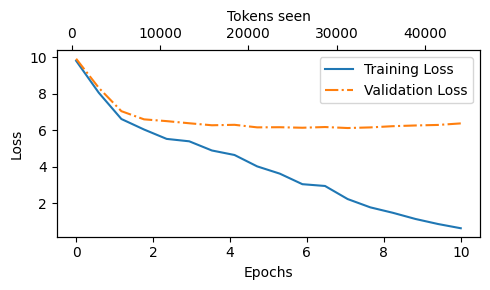

In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# MaxNLocator -> tries to select resonable num of ticks with integer values instead of decimel points


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize =(5,3))
    ax1.plot(epochs_seen, train_losses, label= 'Training Loss')
    ax1.plot(epochs_seen, val_losses, linestyle ='-.', label = 'Validation Loss')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc= 'upper right')

    ax1.xaxis.set_major_locator(MaxNLocator(integer = True))
    ax2 = ax1.twiny() # creates a twin x-axis (shared y-axis) for existing axis ax1

    ax2.plot(token_seen, train_losses, alpha=0) # alpha = 0 -> invisible plot
    ax2.set_xlabel('Tokens seen')
    fig.tight_layout()
    plt.show()



epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

It looks like our model is overfitting to the training data

#### Decoding Strategies
ways to introduce randomness in the output.

1. *temperature scaling*

2. *top-k sampling*

In [49]:
# print output text using our pretrained model

model.to('cpu')
model.eval()

tokenizer = tiktoken.get_encoding('gpt2')
token_ids = generate_text_simple(model= model,
                                 idx= text_to_token_ids('Every effort moves you', tokenizer),
                                 max_new_tokens= 25,
                                 context_size= GPT_CONFIG_124M['context_length'])


print(f'Output text: {token_ids_to_text(token_ids, tokenizer)}')

Output text: Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




currently our pretrained llm will generate same output even if we run the above cell multiple times...keeping the `start_context` same.

in `generate_text_simple` we are selecting token with max probability as next token...known as greddy decoding.

now, we will use probabilistic sampling for next token selection using `torch.multinomial`

In [50]:
# illustration

import torch

vocab ={"closer": 0,
        "every": 1,
        "effort": 2,
        "forward": 3,
        "inches": 4,
        "moves": 5,
        "pizza": 6,
        "toward": 7,
        "you": 8}

inv_vocab = {v:k for k, v in vocab.items()}


# let's say llm returns following next-token logits given start_context ='Every effort moves you'
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
inv_vocab[next_token_id], probas

('forward',
 tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
         1.0120e-04, 3.5758e-01, 4.0122e-03]))

`.multinomial()`: to sample elements from a given probability distribution

In [53]:
# let's do the same using probabilistic sampling

torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
inv_vocab[next_token_id]

'toward'

In [54]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]  # 1_000 is same as 1000(just for better readability)

    sampled_ids = torch.bincount(torch.tensor(sample)) # to count occurence

    for i, freq in enumerate(sampled_ids):
        print(f'{freq} X {inv_vocab[i]}')

print_sampled_tokens(probas)

71 X closer
2 X every
0 X effort
544 X forward
2 X inches
1 X moves
0 X pizza
376 X toward
4 X you


`temperature scaling` -> logits divided by some number > 0

temperature scaling is used to calibrate the confidence of a classification model;s predicted probabilities

1. T = 1, normal softmax
2. T> 1, softens probas (dec confidence)
3. T< 1, sharpens probas (inc confidence)

In [55]:
def softmax_with_temp(logits, temp):
    scaled_logits = logits/temp
    return torch.softmax(scaled_logits, dim=0)

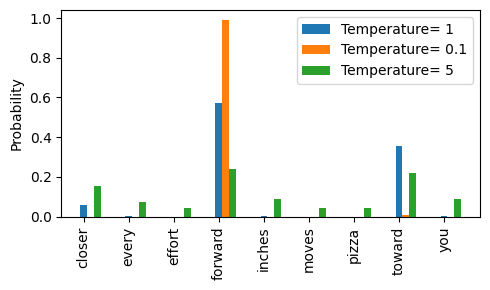

In [59]:
# illustration

temps =[1,0.1,5]
scaled_probas = [softmax_with_temp(next_token_logits, t) for t in temps]

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize= (5,3))
for i, t in enumerate(temps):
    rects = ax.bar(x+ i*bar_width, height=scaled_probas[i], width= bar_width,
                   label= f'Temperature= {t}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

Higher temperature -> more uniformly distributed probabilities

`Top-k Sampling` -> limits sampling to k most probable tokens and exclude all other tokens by masking their probability scores

In [62]:
top_k = 3
topk_logits, topk_indices = torch.topk(next_token_logits, top_k)

print('topk logits', topk_logits)
print('topk indices', topk_indices)

topk logits tensor([6.7500, 6.2800, 4.5100])
topk indices tensor([3, 7, 0])


In [64]:
# setting logits below the minimum topk_logits equal to -inf

new_logits = torch.where(condition=next_token_logits < topk_logits.min(),
                         input=torch.tensor(-float('inf')),
                         other=next_token_logits)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [65]:
topk_probas = F.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Now we can apply temperature scaling and multinomial function on these topk_probas

In [66]:
# modify the generate_text_simple function

def generate(model,idx, max_new_tokens, context_size, temp=0.0,
             top_k = None, eos_id = None):
  for _ in range(max_new_tokens):
        # crops the current context(initial tokens) to fit model's max context size
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)  # shape (batch, n_token, vocab_size)

        logits = logits[:, -1, :]  # to extracts the last vector, shape -> (batch, vocab_size)

        if top_k is not None:
          topk_logits, _= torch.topk(logits, top_k)
          logits = torch.where(condition=logits < topk_logits.min(),
                               input=torch.tensor(-float('inf')).to(logits.device),
                               other=logits)

        if temp >0.0:
          logits = logits/temp
          probs = F.softmax(logits, dim=-1)
          idx_next = torch.multinomial(probs, num_samples=1)
        else:
          idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if eos_id is not None and idx_next == eos_id:
          break

        idx = torch.cat((idx, idx_next), dim=1)
  return idx


In [78]:
torch.manual_seed(123)
token_ids = generate(
    model= model,
    idx= text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens= 20,
    context_size= GPT_CONFIG_124M['context_length'],
    top_k=30,
    temp= 1.5,
)

print(f'Output Text: \n {token_ids_to_text(token_ids, tokenizer)}')

Output Text: 
 Every effort moves you know began to happen a hint a little it was such a good; and watched at the end would


#### Saving and loading the model

In [81]:
torch.save(model.state_dict(), 'pretrained_gpt2_model.pth')

In [84]:
import os

file_path = "pretrained_gpt2_model.pth"
size_in_bytes = os.path.getsize(file_path)
print(f"File size: {size_in_bytes/(1024*1024)} MB")


File size: 622.6430110931396 MB


In [89]:
# loading the model

model= GPTModel(config=GPT_CONFIG_124M)
model.load_state_dict(torch.load('pretrained_gpt2_model.pth',map_location= device))
model.eval();

In [87]:
# saving model and optimizer both
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'model_and_optimizer.pth')

In [88]:
# loading model and optimizer

checkpoint = torch.load('model_and_optimizer.pth', map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.train();